In [9]:
# !ls ../../datasets/VLSP2023_public_test/wav/0000001975.wav
import os
import sys 
sys.path.append(os.getcwd()) # NOQA


In [1]:
import librosa
wav, sr = librosa.load("00000001.wav")
print(sr)

22050


In [27]:
# wav = "../../datasets/tmp/0000000019.wav"
# 
# from IPython.display import Audio
# Audio(wav)


In [1]:
import numpy as np
import IPython.display as ipd
from scipy.signal.windows import hamming
from scipy.io import wavfile
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 5) # set the figure size
plt.rcParams['axes.grid'] = True  # set the grid on

In [25]:
def read_wav(filename):
    """
        read wav file.
        Normalizes signal to values between -1 and 1.
    """
    fs, s = wavfile.read(filename)  # scipy reads int
    s = np.array(s)/float(max(abs(s)))
    return fs,s

# test_file='sounds/testVoice.wav'
test_file = "file_example_WAV_2MG.wav"
samplerate,data = read_wav(test_file)
ipd.Audio(data, rate=samplerate)

c:\Users\Asus\anaconda3\envs\cs224n\lib\site-packages\ipykernel_launcher.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [3]:
def enframe(x, win_len, hop_len):
    """
        receives a 1D numpy array and divides it into frames.
        outputs a numpy matrix with the frames on the rows.
    """
    x = np.squeeze(x)
    if x.ndim != 1:
        raise TypeError("enframe input must be a 1-dimensional array.")
    n_frames = 1 + np.int64(np.floor((len(x) - win_len) / float(hop_len)))
    x_framed = np.zeros((n_frames, win_len))
    for i in range(n_frames):
        x_framed[i] = x[i * hop_len : i * hop_len + win_len]
    return x_framed


def deframe(x_framed, win_len, hop_len):
    """
        interpolates 1D data with framed alignments into persample values.
        This function helps as a visual aid and can also be used to change 
        frame-rate for features, e.g. energy, zero-crossing, etc.
    """
    n_frames = len(x_framed)
    n_samples = (n_frames-1)*hop_len + win_len
    x_samples = np.zeros((n_samples,1))
    for i in range(n_frames):
        x_samples[i*hop_len : i*hop_len + win_len] = x_framed[i].reshape(-1,1)
    return x_samples

In [4]:
def compute_nrg(xframes):
    """
        calculate per frame energy
    """
    n_frames = xframes.shape[1]
    hamm_window = hamming(n_frames)
    weighted_matrix = xframes * hamm_window
    return np.diagonal(np.dot(weighted_matrix,weighted_matrix.T))/float(n_frames)

def compute_log_nrg(xframes):
    """
        calculate per frame energy in log
    """
    n_frames = xframes.shape[1]
    raw_nrgs = np.log(compute_nrg(xframes+1e-5))/float(n_frames)
    return (raw_nrgs - np.mean(raw_nrgs))/(np.sqrt(np.var(raw_nrgs)))

In [5]:
def zero_mean(xframes):
    """
        remove mean of framed signal
        return zero-mean frames.
    """
    m = np.mean(xframes,axis=1)
    xframes = xframes - np.tile(m,(xframes.shape[1],1)).T
    return xframes

In [6]:
#eps : kernel bandwidth     
def k_cal(x, y, eps=0.5):
    """
        calculate k value
    """
    dist = x - y
    p = -1*np.dot(dist, dist.T)/(2*eps*eps)
    return np.exp(p)
    
def nrg_vad(xframes,thr=0.2):
    xframes = zero_mean(xframes) #u0..u[N]
    n_frames = xframes.shape[0]
    # Compute per frame energies:
    xnrgs = compute_log_nrg(xframes) #f0..f[N]
    xvad = np.zeros((n_frames,1))
    for i in range(1, n_frames):
        if k_cal(xframes[0], xframes[i]) <= thr:
            xvad[i] = 1.
        else:
            xvad[i] = 0.
    return xvad

In [26]:
# test_file='sounds/testVoice.wav'
test_file = "00000001.wav"
samplerate,data = read_wav(test_file)
ipd.Audio(data, rate=samplerate)

In [27]:
win_len = int(samplerate*0.025)
hop_len = int(samplerate*0.010)
init_silence_len = int(0.1*samplerate) # it is assumed that the first 100ms doesnt contain any speech
sframes = enframe(data,win_len,hop_len) # rows: frame index, cols: each frame

Exception ignored in: <function Wave_write.__del__ at 0x0000022C62120E58>
Traceback (most recent call last):
  File "c:\Users\Asus\anaconda3\envs\cs224n\lib\wave.py", line 327, in __del__
    self.close()
  File "c:\Users\Asus\anaconda3\envs\cs224n\lib\wave.py", line 445, in close
    self._ensure_header_written(0)
  File "c:\Users\Asus\anaconda3\envs\cs224n\lib\wave.py", line 468, in _ensure_header_written
    self._write_header(datasize)
  File "c:\Users\Asus\anaconda3\envs\cs224n\lib\wave.py", line 485, in _write_header
    self._sampwidth * 8, b'data'))
struct.error: ushort format requires 0 <= number <= 0xffff


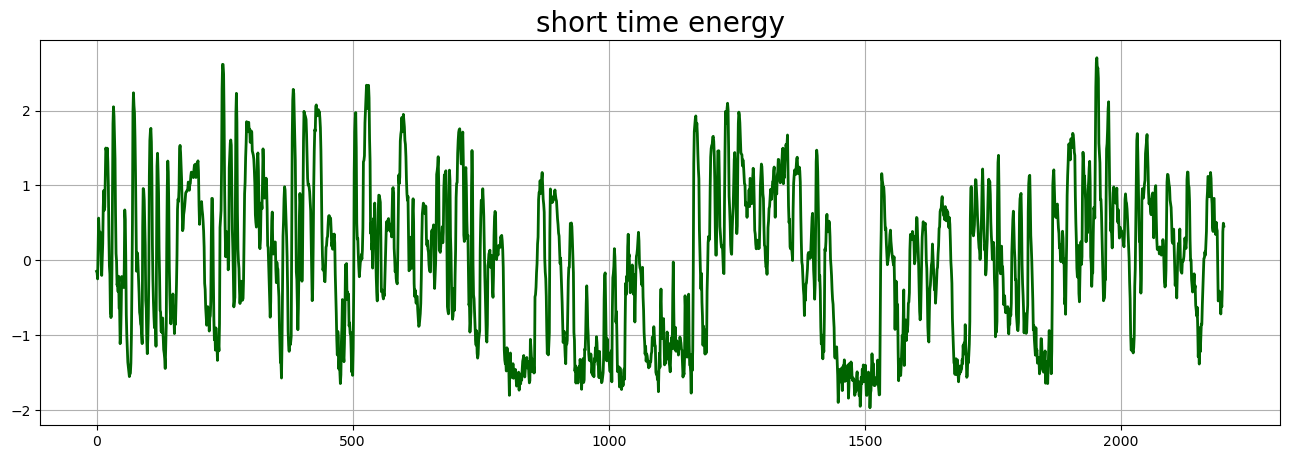

In [28]:
energy = compute_log_nrg(sframes)

plt.plot(energy, color='darkgreen', linewidth=2)
plt.title("short time energy", fontsize=20)
plt.savefig('energy plot.png')
plt.show()

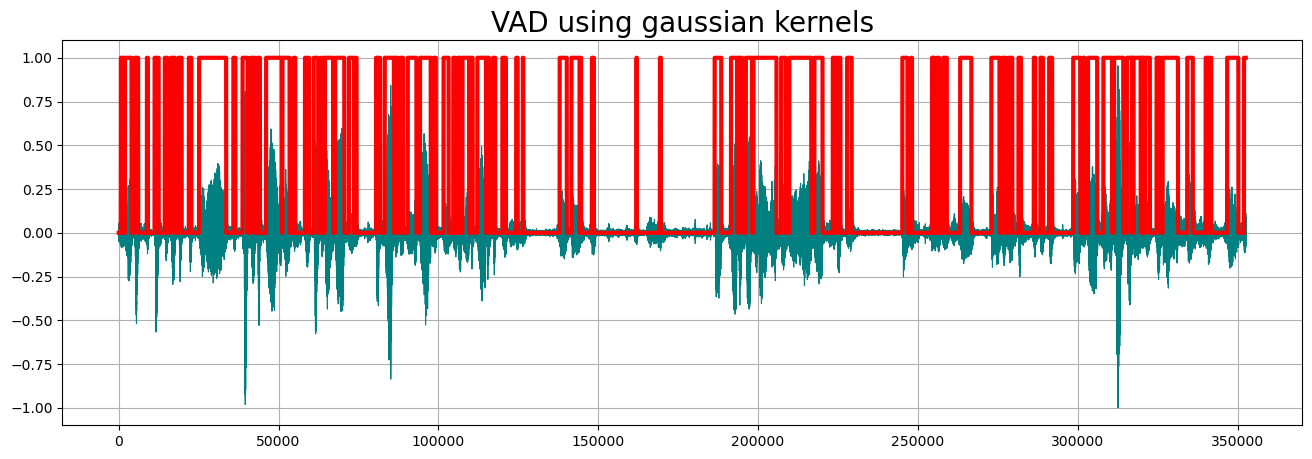

In [29]:
vad2 = nrg_vad(sframes)
x = deframe(vad2,win_len,hop_len)
x = x.squeeze()
plt.plot(data/max(abs(data)),color='#008080', linewidth=0.8)
plt.plot(x/max(abs(x)),color='red', linewidth=3)
plt.title("VAD using gaussian kernels", fontsize=20)
plt.savefig('VAD using gaussian kernels.png')
plt.show()

In [30]:
def trim_and_concat_all(speech, vad):
    """
        trim the silence from the beginning and end of the speech
        concatenate all the speech segments
    """
    speech = speech.squeeze()
    vad = vad.squeeze()
    start = 0
    end = 0
    for i in range(len(vad)):
        if vad[i] == 1:
            start = i
            break
    for i in range(len(vad)-1,0,-1):
        if vad[i] == 1:
            end = i
            break
    return speech[start*hop_len:end*hop_len]

## Inference

In [31]:
test_file = "00000001.wav"
samplerate,data = read_wav(test_file)
ipd.Audio(data, rate=samplerate)

# win_len = int(samplerate*0.025)
# hop_len = int(samplerate*0.010)
# init_silence_len = int(0.1*samplerate) # it is assumed that the first 100ms doesnt contain any speech
sframes = enframe(data,win_len,hop_len) # rows: frame index, cols: each frame

vad2 = nrg_vad(sframes)
x = deframe(vad2,win_len,hop_len)
x = x.squeeze()

speech = trim_and_concat_all(data, vad2)

# save 
# wavfile.write('speech.wav', samplerate, speech)
import soundfile as sf
sf.write('speech.wav', speech, samplerate)

In [32]:
# play
from IPython.display import Audio
Audio('speech.wav')